In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import itertools

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import LearningRateScheduler

print(tf.__version__)

Init Plugin
2.5.0Init Graph Optimizer
Init Kernel



In [3]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["savefig.format"] = 'pdf'
plt.rcParams.update({'font.size': 16})

In [4]:
# Define constants
synch_phase=-32/180*np.pi
rf_freq_L=201.24e6
rf_freq_H=804.96e6
proton_mass=938272088.16
electron_mass=510998.95
pmass= proton_mass+2*electron_mass
light_v=299792458

In [5]:
# LE design energy & energy gain
L_energy = np.multiply([0.75,0.80248,0.85820,0.91708,0.97923,1.04473,1.11367,1.18614,1.26220,1.34194,
            1.42543,1.51274,1.60393,1.69909,1.79826,1.90152,2.00894,2.12059,2.23463,2.34869,
            2.46703,2.58974,2.71694,2.84871,2.98516,3.12638,3.27246,3.42351,3.57961,3.74088,
            3.90739,4.07926,4.25658,4.43944,4.62794,4.82218,5.02226,5.22828,5.44033,5.65853,
            5.88298,6.11377,6.35103,6.59485,6.84536,7.10267,7.36691,7.63820,7.91667,8.20247,
            8.49573,8.79662,9.10529,9.42192,9.74669,10.07979,
            10.421,10.421,10.74471,11.07302,11.40634,11.74462,12.08784,12.43599,12.78901,13.14690,
            13.50961,13.87711,14.24937,14.62636,15.00804,15.39438,15.78543,16.18108,16.58129,16.98602,
            17.39523,17.80889,18.22695,18.64938,19.07613,19.50717,19.94245,20.38194,20.82560,21.27338,
            21.72524,22.18114,22.64105,23.10491,23.57269,24.04435,24.51984,24.99913,25.48217,25.96892,
            26.45935,26.95341,27.45106,27.95227,28.45698,28.96518,29.47681,29.99183,30.51022,31.55691,
            32.08515,32.61660,33.15123,33.6889,34.22986,34.77380,35.32078,35.87076,36.42371,36.97961,
            37.53840,37.53840,38.28487,39.03687,39.79378,40.55553,41.32205,42.09325,42.8697,43.64943,
            44.43426,45.22349,46.01705,46.81486,47.61686,48.42296,49.23311,50.04724,50.86526,51.68712,
            52.51275,53.34207,54.17503,55.01154,55.85156,56.69500,57.54181,58.39192,59.24526,60.10178,
            60.96140,61.82407,62.68972,63.55829,64.42972,
            65.30395,66.18092,66.18092,67.06008,67.94235,68.82717,69.71449,70.60426,71.49642,72.3909,
            73.28766,74.18664,75.08779,75.99105,76.89636,77.80368,78.71294,79.62411,80.53713,81.45194,
            82.36849,83.28675,84.20665,85.12814,86.05119,86.97574,87.90175,88.82917,89.75794,90.68804,91.61940,
            92.55200,92.552,93.53635,94.52273,95.51059,96.49991,97.49065,98.48278,
            99.47627,100.47109,101.46721,102.46459,103.46321,104.46303,105.46403,106.46618,107.46944,
            108.47379,109.47919,110.48563,111.49307,112.50148,113.51084,114.52111,115.53228,116.54431
         ],1e6)

dE_L = []
for i in range(len(L_energy) - 1):
    dE_L.append(L_energy[i+1] - L_energy[i])
dE_L.append(0)

In [6]:
T5_energy =np.multiply([92.55200,92.552,93.53635,94.52273,95.51059,96.49991,97.49065,98.48278,
            99.47627,100.47109,101.46721,102.46459,103.46321,104.46303,105.46403,106.46618,107.46944,
            108.47379,109.47919,110.48563,111.49307,112.50148,113.51084,114.52111,115.53228,116.54431
         ],1e6)

dE_T5 = []
for i in range(len(T5_energy) - 1):
    dE_T5.append(T5_energy[i+1] - T5_energy[i])
dE_T5.append(0)

In [7]:
# HE design energy & energy gain
H_energy = np.multiply([116.54431,125.1,133.8,142.8,
                        152.1,161.2,170.6,180.2,
                        190.0,199.7,209.5,219.5,
                        229.8,239.9,250.1,260.5,
                        271.1,281.5,292.1,302.8,
                        313.8,324.4,335.2,346.1,
                        357.1,368.1,379.1,390.2,401.5],1e6)

# Interpolation for every cell
interpolated = []
for i in range(len(H_energy) - 1):
    increment = (H_energy[i+1] - H_energy[i]) / 16
    for j in range(16):
        interpolated.append(H_energy[i] + j * increment)
interpolated.append(H_energy[-1])


dE_H = []
for i in range(len(interpolated) - 1):
    dE_H.append(interpolated[i+1] - interpolated[i])
dE_H.append(0)

In [8]:
# HE cell & drift lengths from design geometry
modL = [
    [1.3814,1.4215,1.4606,1.4987],
    [1.5353,1.5704,1.6046,1.6380],
    [1.6700,1.7008,1.7308,1.7600],
    [1.7881,1.8151,1.8414,1.8670],
    [1.8917,1.9155,1.9386,1.9612],
    [1.9829,2.0039,2.0244,2.0443],
    [2.0635,2.0821,2.1002,2.1179]
]

# Drift lengths from design
gapL = [
    [0.1418,0.2628,0.2703,0.2775],
    [0.2846,0.2912,0.2977,0.3041],
    [0.3102,0.3162,0.3218,0.3273],
    [0.3327,0.3379,0.3428,0.3477],
    [0.3524,0.3570,0.3614,0.3657],
    [0.3698,0.3728,0.3777,0.3815],
    [0.3852,0.3887,0.3921,0.3955]
]

In [9]:
# LE dataframe
df_L = pd.DataFrame(L_energy)
df_L.columns =['Energy_cell']
df_L["delE"]=dE_L
df_L["V"] = df_L["delE"]/np.cos(synch_phase)
df_L["Gamma"] = (df_L["Energy_cell"]+pmass)/pmass
df_L['Beta']=np.sqrt(1-1/df_L['Gamma']/df_L['Gamma'])
df_L['L']=df_L['Beta']*light_v/rf_freq_L    ##2pi-mode cavity
df_L['L2'] = df_L['L']

In [10]:
# T5 dataframe
df_t5 = pd.DataFrame(T5_energy)
df_t5.columns =['Energy_cell']
df_t5["delE"]=dE_T5
df_t5["V"] = df_t5["delE"]/np.cos(synch_phase)
df_t5["Gamma"] = (df_t5["Energy_cell"]+pmass)/pmass
df_t5['Beta']=np.sqrt(1-1/df_t5['Gamma']/df_t5['Gamma'])
df_t5['L']=df_t5['Beta']*light_v/rf_freq_L    ##2pi-mode cavity
df_t5['L2'] = df_t5['L']

In [11]:
#df_L['L'].iloc[207] = 0.69
df_t5.tail(10)

,Energy_cell,delE,V,Gamma,Beta,L,L2
16,107469440.0,1004350.0,1.184308e+06,1.114415,0.441357,0.657501,0.657501
17,108473790.0,1005400.0,1.185546e+06,1.115484,0.443101,0.660100,0.660100
18,109479190.0,1006440.0,1.186772e+06,1.116555,0.444836,0.662683,0.662683
19,110485630.0,1007440.0,1.187951e+06,1.117626,0.446560,0.665253,0.665253
20,111493070.0,1008410.0,1.189095e+06,1.118699,0.448275,0.667807,0.667807
21,112501480.0,1009360.0,1.190216e+06,1.119772,0.449980,0.670347,0.670347
22,113510840.0,1010270.0,1.191289e+06,1.120847,0.451675,0.672872,0.672872
23,114521110.0,1011170.0,1.192350e+06,1.121923,0.453361,0.675383,0.675383
24,115532280.0,1012030.0,1.193364e+06,1.122999,0.455037,0.677880,0.677880
25,116544310.0,0.0,0.000000e+00,1.124076,0.456703,0.680362,0.680362


In [12]:
# HE dataframe
df_H = pd.DataFrame(interpolated)
df_H.columns =['Energy_cell']
df_H["delE"]=dE_H
df_H["V"] = df_H["delE"]/np.cos(synch_phase)
df_H["Gamma"] = (df_H["Energy_cell"]+pmass)/pmass
df_H['Beta']=np.sqrt(1-1/df_H['Gamma']/df_H['Gamma'])
df_H['L']=df_H['Beta']*light_v/rf_freq_H/2    ##pimode cavity

cells = []
gaps = []
for i in range(7):
    for j in range(4):
        for k in range(16):
            cells.append(modL[i][j]/16.0)
            gaps.append(gapL[i][j])

cells.append(gaps[-1])
print(len(cells))
df_H['L2'] = cells

for i in range(1,28):
    n=i*16-1
    df_H.loc[n+0.5]=df_H.loc[n+1]
    df_H.loc[n+0.5,'V']=0
    df_H.loc[n+0.5,'delE']=0
    df_H.loc[n+0.5,'L']=float(df_H.loc[n+0.5,'L']*4)
    df_H.loc[n+0.5,'L2']=float(gaps[n])
    #df_H.loc[n+0.5,'L2']=float(df_H.loc[n+0.5,'L2']*4)

df_H = df_H.sort_index().reset_index(drop=True)

df_H.tail()

449


,Energy_cell,delE,V,Gamma,Beta,L,L2
471,398675000.0,706250.0,832794.747374,1.424441,0.712148,0.132613,0.132369
472,399381250.0,706250.0,832794.747374,1.425193,0.712513,0.132681,0.132369
473,400087500.0,706250.0,832794.747374,1.425945,0.712877,0.132749,0.132369
474,400793750.0,706250.0,832794.747374,1.426697,0.713240,0.132817,0.132369
475,401500000.0,0.0,0.000000,1.427449,0.713603,0.132884,0.395500


In [13]:
# Combine LE and HE
df=pd.concat([df_L,df_H])
df = df.reset_index(drop=True)

#df.iloc[207,5] = df.iloc[207,5]*5.25
#df.iloc[60:120]
df.head()

df2=pd.concat([df_t5,df_H])
df2 = df2.reset_index(drop=True)
#df2.iloc[25,5] = df2.iloc[25,5]*5.25


In [14]:
# Generate particles

def circle_points(r, n):
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 2*np.pi, n, endpoint=False)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

def generate_part_synch(synch_energy, synch_phase,n,vis=False):
    Ep=[]
    Tp=[]
    
    for nn in n:
        Ep.append(np.ones(nn)*synch_energy)
        Tp.append(np.zeros(nn)) 

    if vis:
        fig, ax = plt.subplots()
        [ax.scatter(t,e) for t,e in zip(Tp,Ep)]
        ax.grid()
    
        
    particles = [[{'initE': E, 'initT':T} for E,T in zip(Ep[i],Tp[i])] for i in range(len(Ep))]
    df_part=[pd.DataFrame.from_dict(part) for part in particles]

    if len(df_part)==1:
        df_part = df_part[0]

    return df_part   

def generate_part_circle(init_energy,init_phase,synch_phase,rf_freq,rP,rE,n,vis=False):
    Ep=[]
    Tp=[]
    Pp=[]
    circles = circle_points(r, n)
    for i,circle in enumerate(circles):
        Ep.append(np.add(circle[:,1]/(rP[i]/rE[i]),init_energy))
        Pp.append(np.add(circle[:,0],init_phase))
        Tp.append((np.add(circle[:,0],init_phase) - synch_phase)/360.0/rf_freq)

    if vis:
        fig, ax = plt.subplots()
        [ax.scatter(p,e) for p,e in zip(Pp,Ep)]
        ax.grid()
    
        
    particles = [[{'initE': E, 'initT':T,'initP':P} for E,T,P in zip(Ep[i],Tp[i],Pp[i])] for i in range(len(Ep))]
    df_part=[pd.DataFrame.from_dict(part) for part in particles]

    if len(df_part)==1:
        df_part = df_part[0]

    return df_part    

def generate_part_gauss(init_energy, init_phase,synch_phase,rf_freq,rP,rE,n,vis=False):
    Ep=[]
    Tp=[]
    Pp=[]

    for rp,re,nn in zip(rP,rE,n):
        samples = np.random.multivariate_normal([init_phase, init_energy], [[rP[0]**2/4., 1],[1, rE[0]**2/4.]], n[0])
        Ep.append(samples[:,1])
        Pp.append(samples[:,0])
        Tp.append(np.subtract(samples[:,0],synch_phase)/360./rf_freq)

    if vis:
        fig, ax = plt.subplots()
        [ax.scatter(p,e) for p,e in zip(Pp,Ep)]
        ax.grid()
    
        
    particles = [[{'initE': E, 'initT':T,'initP':P} for E,T,P in zip(Ep[i],Tp[i],Pp[i])] for i in range(len(Ep))]
    df_part=[pd.DataFrame.from_dict(part) for part in particles]

    if len(df_part)==1:
        df_part = df_part[0]

    
    return df_part    

In [15]:

def propagate(df,synch_phase,synch_energy,
              init_phase,init_energy,init_length,
              rf_freq_L,rf_freq_H,last_LE_cell):
    
    #initialize
    
    E = []
    dE = []
    dPhi = []
    l = []

    light_v=299792458
    
    total_length= init_length

    energy = init_energy
    T = (init_phase - synch_phase)/360.0/rf_freq_L
    
    T_synch=0

    #fill initial conditions
    E.append(energy)
    dE.append(energy-synch_energy)
    dPhi.append((T-T_synch)*rf_freq_L*360)
    l.append(total_length)
    
    for turn in range (0,len(df)-1):
        #synch_energy=df.iloc[turn+1,df.columns.get_indexer(['Energy_cell'])].values[0]
        voltage=df.iloc[turn,df.columns.get_indexer(['V'])].values[0]
        length=df.iloc[turn,df.columns.get_indexer(['L'])].values[0]
        gamma=(pmass+energy)/pmass
        if gamma<=0:
            beta=1
        else:
            beta=np.sqrt(1-1/gamma/gamma)
            
        
        if turn < last_LE_cell:
            if voltage==0:
                T_synch = T_synch + 1/rf_freq_L
            else:
                T_synch = T_synch + 1/rf_freq_L
        elif turn==last_LE_cell:
            T_synch = T_synch + 1*1/rf_freq_L
        else:
            if voltage==0:
                T_synch = T_synch + 2.0*(1/rf_freq_H)
            else:
                T_synch = T_synch + 0.5*(1/rf_freq_H)


        T=T+length/(beta*light_v)
 
        if turn < last_LE_cell:
            del_phase =(T-T_synch)*rf_freq_L*2*np.pi
        elif turn == last_LE_cell:
            del_phase =(T-T_synch)*rf_freq_L*2*np.pi*4 #rf_freq_H?
        else:
            del_phase =(T-T_synch)*rf_freq_H*2*np.pi
                     
        energy = energy + voltage*np.cos((synch_phase/180*np.pi)+del_phase)
        synch_energy = synch_energy + voltage*np.cos((synch_phase)/180*np.pi)        
        del_energy=energy-synch_energy
        del_phase_deg=del_phase*180/np.pi

        total_length=total_length+length
        
        dPhi.append(del_phase_deg)
        dE.append(del_energy)
        E.append(energy)
        l.append(total_length)
        
    particle_prop = pd.DataFrame({'E':E,'dE':dE, 'dPhi':dPhi,'l':l})

    return particle_prop


In [16]:
def propagate_RFkick(df,synch_phase,synch_energy,
              init_phase,init_energy,init_length,
              rf_freq_L,rf_freq_H,last_LE_cell,rfdict):
    
    #initialize
    
    E = []
    dE = []
    dPhi = []
    l = []

    light_v=299792458
    
    total_length= init_length

    energy = init_energy
    T = (init_phase - synch_phase)/360.0/rf_freq_L
    
    T_synch=0

    #fill initial conditions
    E.append(energy)
    dE.append(energy-synch_energy)
    dPhi.append((T-T_synch)*rf_freq_L*360)
    l.append(total_length)
    
    for turn in range (0,len(df)-1):
        #synch_energy=df.iloc[turn+1,df.columns.get_indexer(['Energy_cell'])].values[0]
        voltage=df.iloc[turn,df.columns.get_indexer(['V'])].values[0]
        length=df.iloc[turn,df.columns.get_indexer(['L'])].values[0]
        gamma=(pmass+energy)/pmass
        if gamma<=0:
            beta=1
        else:
            beta=np.sqrt(1-1/gamma/gamma)

        if turn in rfdict.keys():
            T= T - float(rfdict[turn])/360.0/rf_freq_L 
            
        if turn < last_LE_cell:
            if voltage==0:
                T_synch = T_synch + 1/rf_freq_L
            else:
                T_synch = T_synch + 1/rf_freq_L
        elif turn==last_LE_cell:
            T_synch = T_synch + 1*1/rf_freq_L
        else:
            if voltage==0:
                T_synch = T_synch + 2.0*(1/rf_freq_H)
            else:
                T_synch = T_synch + 0.5*(1/rf_freq_H)


        T=T+length/(beta*light_v)
 
        if turn < last_LE_cell:
            del_phase =(T-T_synch)*rf_freq_L*2*np.pi
        elif turn == last_LE_cell:
            del_phase =(T-T_synch)*rf_freq_L*2*np.pi*4 #rf_freq_H?
        else:
            del_phase =(T-T_synch)*rf_freq_H*2*np.pi
                     
        energy = energy + voltage*np.cos((synch_phase/180*np.pi)+del_phase)
        synch_energy = synch_energy + voltage*np.cos((synch_phase)/180*np.pi)        
        del_energy=energy-synch_energy
        del_phase_deg=del_phase*180/np.pi

        total_length=total_length+length
        
        dPhi.append(del_phase_deg)
        dE.append(del_energy)
        E.append(energy)
        l.append(total_length)
        
    particle_prop = pd.DataFrame({'E':E,'dE':dE, 'dPhi':dPhi,'l':l})

    return particle_prop


In [17]:
def propagate_many_fromT5(df,initparts):

    partdfs = []
    
    Ep = initparts['initE'].values.squeeze()
    Pp = initparts['initP'].values.squeeze()
    
    for i,(E_i,P_i) in enumerate(zip(Ep,Pp)):

        init_length= 61.99 # start of Tank5
    
        synch_phase=-32.0
        synch_energy= 92.552e6 #start of Tank5

        init_energy = E_i #synch_energy+0.00e6
        init_phase = P_i#synch_phase+0
    
        #Last LE turn
        last_LE_cell = len(df_t5)-1
    
        partdfs.append(propagate(df,synch_phase,synch_energy,init_phase,init_energy,init_length,
              rf_freq_L,rf_freq_H,last_LE_cell))

    return partdfs
    

In [18]:
def propagate_many_fromT1(df,initparts):

    partdfs = []
    
    Ep = [initparts['initE'].values.squeeze()]
    Pp = [initparts['initP'].values.squeeze()]
    
    for i,(E_i,P_i) in enumerate(zip(Ep,Pp)):

        init_length= 0
        
        synch_phase=-32.0
        synch_energy= 0.75e6

        init_energy = E_i #synch_energy+0.00e6
        init_phase = P_i#synch_phase+0
    
        #Last LE turn
        last_LE_cell = len(df_L)-1
    
        partdfs.append(propagate(df,synch_phase,synch_energy,init_phase,init_energy,init_length,
              rf_freq_L,rf_freq_H,last_LE_cell))

    return partdfs


In [19]:
def plot_phase_osc(dfs,N,save=False):
    %matplotlib widget

    if N==-1:
        N=len(dfs)
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    fig.suptitle('Synchrotron oscillation along the linac',fontsize='x-large')
    [ax.plot(df['l'],df['dPhi']) for df in dfs[:int(N)]]
    ax.set_xlim(0,150)
    ax.set_xlabel('Distance (m)', fontsize=18)
    ax.set_ylabel('$\Delta \phi$ (deg)',fontsize=18)
    ax.xaxis.grid(True, which='major')
    ax.yaxis.grid(True, which='major')
    ax.tick_params(axis='both',labelsize='x-large')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplots_adjust(bottom=0.18)
    plt.subplots_adjust(top=0.90)
    plt.subplots_adjust(left=0.15)
    plt.subplots_adjust(right=0.99)
    if save:
        plt.savefig('phase_oscillation.png')

In [32]:
def plot_phase_osc_select(dfs,Ns,save=False):
    %matplotlib widget
    plt.rcParams.update({'font.size': 16, 'font.family': "Times New Roman",
                     'mathtext.fontset': 'cm', 'savefig.format' : 'pdf'})

    
    dfs = [dfs[idx] for idx in Ns]
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    #fig.suptitle('Synchrotron oscillation along the linac',fontsize=18)
    [ax.plot(df['l'],df['dPhi']) for df in dfs]
    ax.set_xlim(0,150)
    ax.set_xlabel('Distance (m)', fontsize='xx-large')
    ax.set_ylabel('$\Delta \phi$ (deg)',fontsize='xx-large')
    ax.xaxis.grid(True, which='major')
    ax.yaxis.grid(True, which='major')
    ax.tick_params(axis='both',labelsize='xx-large')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplots_adjust(bottom=0.2)
    plt.subplots_adjust(top=0.95)
    plt.subplots_adjust(left=0.15)
    plt.subplots_adjust(right=0.95)
    if save:
        plt.savefig('phase_oscillation')

In [30]:
def plot_all_osc(dfs,N,save=False):
    
    %matplotlib widget
    if N==-1:
        N=len(dfs)
    fig, ax = plt.subplots(3,1, figsize=(9,15))
    #fig.suptitle('Synchrotron oscillation along the linac')
    [ax[0].scatter(df['dPhi'],df['dE']) for df in dfs[:int(N)]]
    ax[0].set_title('Longitudinal phase space')
    ax[0].set(xlabel='$\Delta \phi$ (deg)', ylabel='$\Delta E$ (MeV)')
    [ax[1].plot(df['l'],df['dPhi']) for df in dfs[:int(N)]]
    ax[1].set_title('Phase - location')
    ax[1].set(xlabel='Distance (m)', ylabel='$\Delta \phi$ (deg)')
    [ax[2].plot(df['l'],df['dE']) for df in dfs[:int(N)]]
    ax[2].set_title('Energy - location')
    ax[2].set(xlabel='Distance (m)', ylabel='$\Delta$E (MeV)')
    [ax[i].grid() for i in range(3)]
    #plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplots_adjust(bottom=0.15)
    plt.subplots_adjust(top=0.95)
    plt.subplots_adjust(left=0.15)
    plt.subplots_adjust(right=0.97)

    if save:
        plt.savefig('oscillation_all.png')

In [22]:
def plot_emittance(dfs,Nslice):
    %matplotlib widget

    x = [df['dPhi'].iloc[int(Nslice)] for df in dfs]
    y = [df['dE'].iloc[int(Nslice)] for df in dfs]
    (counts, x_bins, y_bins) = np.histogram2d(x, y,bins=50)
    #plt.hist2d(x[:,int(Nslice)], y[:, int(Nslice)],bins=50,cmap='RdGy')
    #plt.contour(x_bins[:-1],y_bins[:-1],counts.T, cmap='RdGy')
    plt.scatter(x,y);
    plt.title('Emittance at cell %d'%Nslice)
    plt.xlabel('$\Delta \phi$ (deg)')
    plt.ylabel('$\Delta$ E (MeV)')
    plt.grid()

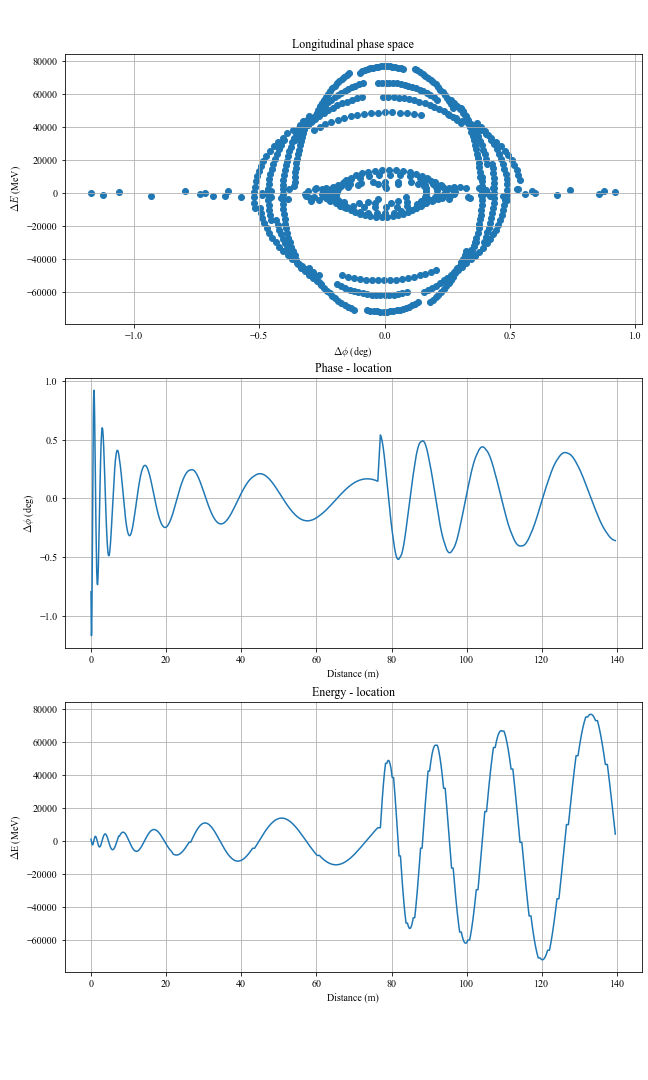

In [563]:
## Propagate many particles with initial emittance LE+HE 

init_energy = 0.75e06 #MeV                                                                                                                                          
init_phase = -32 #deg                                                                                                                                        
synch_phase=-32.0

r = [20] #delta phi in degrees, can take multiple entries                                                                                        
rE = [0.001e6] #delta E in MeV, can take multiple                                                                                                      
n = [1] # number of particles on circle, can take multiple                                                                                          

oneparticle = generate_part_gauss(init_energy,init_phase,synch_phase,rf_freq_L,rP,rE,n,vis=False)


particle=propagate_many_fromT1(df,oneparticle)
plot_all_osc(particle,-1)

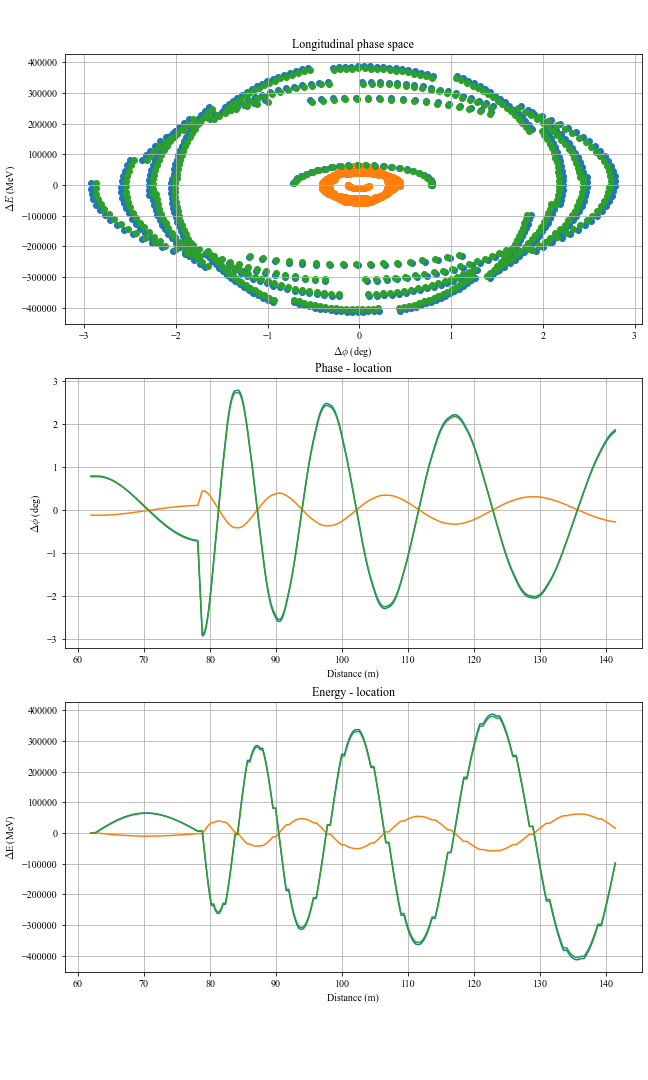

In [545]:
## Propagate many particles with initial emittance only T5+HE
init_energy = 92.552e6#0.75e06 #MeV                                                                                                                                          
init_phase = -32 #deg                                                                                                                                        

rP = [2] #delta phi in degrees, can take multiple entries                                                                                         
rE = [0.001e6] #delta E in MeV, can take multiple                                                                                                       
n = [3] # number of particles on circle, can take multiple                                                                                          


#test = generate_part_circle(init_energy,init_phase,synch_phase,rf_freq_L,rP,rE,n,vis=True)
test = generate_part_gauss(init_energy,init_phase,synch_phase,rf_freq_L,rP,rE,n,vis=False)
#test = generate_part_synch(init_energy,synch_phase,n,vis=False)
test
partdfs=propagate_many_fromT5(df2,test)
plot_all_osc(partdfs,-1)

In [82]:
df.iloc[170:210,:]

,Energy_cell,delE,V,Gamma,Beta,L,L2
170,8.145194e+07,916550.000,1.080776e+06,1.086716,0.391440,0.583139,0.583139
171,8.236849e+07,918260.000,1.082792e+06,1.087692,0.393375,0.586021,0.586021
172,8.328675e+07,919900.000,1.084726e+06,1.088670,0.395299,0.588888,0.588888
173,8.420665e+07,921490.000,1.086601e+06,1.089649,0.397212,0.591737,0.591737
174,8.512814e+07,923050.000,1.088441e+06,1.090630,0.399114,0.594570,0.594570
175,8.605119e+07,924550.000,1.090209e+06,1.091613,0.401005,0.597387,0.597387
176,8.697574e+07,926010.000,1.091931e+06,1.092597,0.402885,0.600188,0.600188
177,8.790175e+07,927420.000,1.093594e+06,1.093583,0.404754,0.602973,0.602973
178,8.882917e+07,928770.000,1.095186e+06,1.094570,0.406613,0.605741,0.605741
179,8.975794e+07,930100.000,1.096754e+06,1.095559,0.408460,0.608494,0.608494


In [28]:
## Propagate synchronous particle with different dPhi at T2 and T5

init_length= 0
        
synch_phase=-32.0
synch_energy= 0.75e6

init_energy = synch_energy+0.00e6
init_phase = synch_phase+0
    
#Last LE turn
last_LE_cell = len(df_L)-1
  
a = np.arange(-5,5.1,1)
b = np.arange(-5,5.1,1)
c = list(itertools.product(a, b))

cells=[116,182]
RFdict = [dict(zip(cells,c[i])) for i in range(len(c))]

#print(RFdict)
T2T5scan = []

for rfd in RFdict:
    testtest = propagate_RFkick(df,synch_phase,synch_energy,init_phase,init_energy,init_length,
              rf_freq_L,rf_freq_H,last_LE_cell,rfd)   

    T2T5scan.append(testtest)


5 55


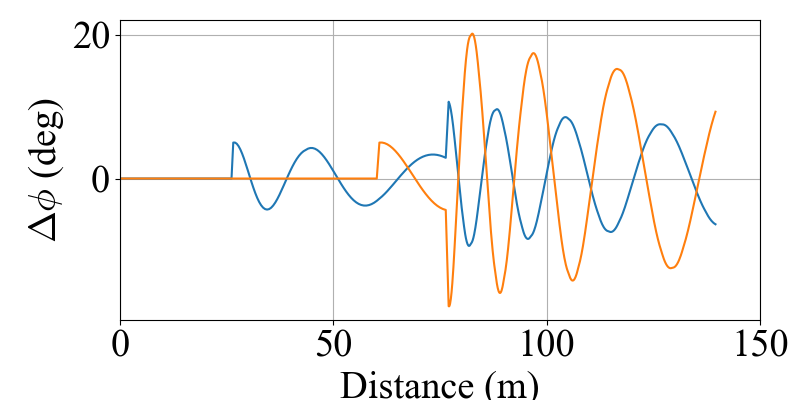

In [33]:
#print(c)
idx1 = c.index((-5,0))
idx2 = c.index((0,-5))
print(idx1,idx2)
#plot_all_osc(,1)

plot_phase_osc_select(T2T5scan,[idx1,idx2])

In [25]:
init_length= 0
        
synch_phase=-32.0
synch_energy= 0.75e6

init_energy = synch_energy+0.00e6
init_phase = synch_phase+0
    
#Last LE turn
last_LE_cell = len(df_L)-1

c = np.arange(-15,15,1)
cells=[0]

RFdict = [dict(zip(cells,[c])) for c in c]

print(RFdict)
T0scan = []

for rfd in RFdict:
    testtest = propagate_RFkick(df,synch_phase,synch_energy,init_phase,init_energy,init_length,
              rf_freq_L,rf_freq_H,last_LE_cell,rfd)   
    T0scan.append(testtest)


[{0: -15}, {0: -14}, {0: -13}, {0: -12}, {0: -11}, {0: -10}, {0: -9}, {0: -8}, {0: -7}, {0: -6}, {0: -5}, {0: -4}, {0: -3}, {0: -2}, {0: -1}, {0: 0}, {0: 1}, {0: 2}, {0: 3}, {0: 4}, {0: 5}, {0: 6}, {0: 7}, {0: 8}, {0: 9}, {0: 10}, {0: 11}, {0: 12}, {0: 13}, {0: 14}]


In [37]:
init_length= 0
        
synch_phase=-32.0
synch_energy= 0.75e6

init_energy = synch_energy+0.00e6
init_phase = synch_phase+0
    
#Last LE turn
last_LE_cell = len(df_L)-1

#c = np.arange(-15,15,1)
c = [-12,12]
cells=[0]

RFdict = [dict(zip(cells,[c])) for c in c]

print(RFdict)
T0 = []

for rfd in RFdict:
    testtest = propagate_RFkick(df,synch_phase,synch_energy,init_phase,init_energy,init_length,
              rf_freq_L,rf_freq_H,last_LE_cell,rfd)   
    T0.append(testtest)


[{0: -12}, {0: 12}]


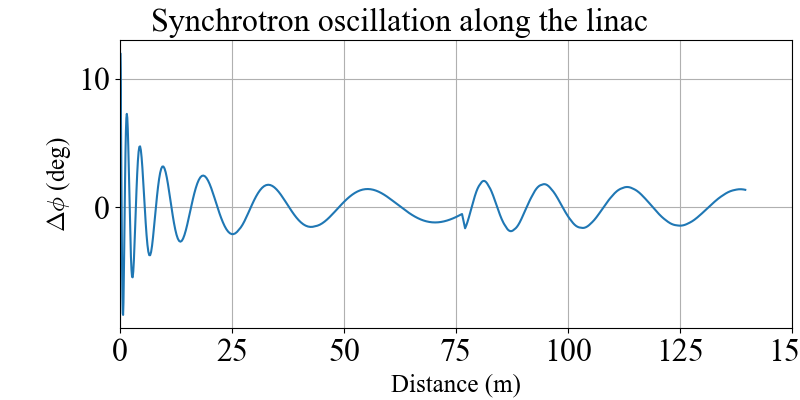

In [38]:
plot_phase_osc(T0,1)

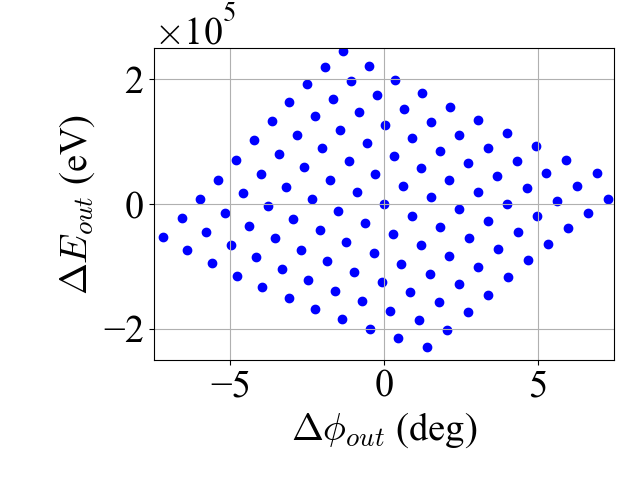

In [35]:
#plot_emittance(T0scan,207)
%matplotlib widget
plt.rcParams.update({'font.size': 16, 'font.family': "Times New Roman",
                     'mathtext.fontset': 'cm', 'savefig.format' : 'pdf',
                    'axes.labelsize': 'xx-large',
                    'axes.titlesize':'xx-large',
                    'xtick.labelsize':'xx-large',
                    'ytick.labelsize':'xx-large',})


[plt.scatter(df['dPhi'].iloc[206],df['dE'].iloc[206],color='b') for df in T2T5scan];
#[plt.scatter(df['dPhi'].iloc[206],df['dE'].iloc[206],color='r') for df in T0scan];

plt.xlabel('$\Delta\phi_{out}$ (deg)')
plt.ylabel('$\Delta E_{out}$ (eV)')


from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((7,8)) 
plt.gca().yaxis.set_major_formatter(formatter) 

#plt.gca().yaxis.get_major_formatter().set_scientific(True)
plt.xlim(-7.5,7.5)
plt.ylim(-250000,250000)
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.subplots_adjust(bottom=0.25)
plt.subplots_adjust(top=0.90)
plt.subplots_adjust(left=0.24)
plt.subplots_adjust(right=0.96)  
plt.grid()

In [133]:
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)


Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1


2023-04-26 06:05:35.355392: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-26 06:05:35.355487: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-04-26 06:05:35.646612: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-26 06:05:35.646803: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-26 06:05:44.429294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-26 06:05:49.004659: I tensorflow/core/grappler/

[[99.694626]]


In [135]:
# demonstrate prediction
x_input = array([108, 118, 128])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[137.67929]]


In [386]:
def build_and_compile_model_nonorm(inputs, init_lr):
  model = keras.Sequential([
      layers.InputLayer(input_shape=(inputs.shape[1],)),
      layers.Dense(20, activation='relu'),#500
      #layers.BatchNormalization(),
      layers.Dense(20, activation='relu'),
      #layers.BatchNormalization(),
      layers.Dense(20, activation='relu'),
      #layers.BatchNormalization(),
      layers.Dense(20, activation='relu'),
      #layers.BatchNormalization(),
      layers.Dense(20, activation='relu'),
      #layers.Dense(20, activation='relu'),
      layers.Dense(2)
  ])

  model.compile(loss='mean_squared_error', #steps_per_execution=30,
                optimizer=tf.keras.optimizers.Adam(init_lr,decay=1e-3 / 200))
  return model

# Define learning schedules 

initial_lr = 0.001

def lr_time_based_decay(epoch, lr):
    epochs = 400
    decay = initial_lr / epochs
    return lr * 1 / (1 + decay * epoch)


def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 200.0
    return initial_lr * math.pow(drop_rate, math.floor(epoch/epochs_drop))

def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_lr * math.exp(-k*epoch)

def train_model(model,features,labels,eps,lrs=None):
    path_checkpoint = "simulation_model_checkpoint.h5"
    es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

    modelckpt_callback = keras.callbacks.ModelCheckpoint(
        monitor="val_loss",
        filepath=path_checkpoint,
        verbose=1,
        save_weights_only=True,
        save_best_only=True,
    )
    
    if lrs is None:
        history = model.fit(
            features, 
            labels,
            validation_split=0.2,
            batch_size=30, #64
            verbose=0,
            epochs=int(eps),
            callbacks=[es_callback, modelckpt_callback]
        )
    else:
        history = model.fit(
            features, 
            labels, 
            validation_split=0.2,
            batch_size=30,
            verbose=0,
            epochs=int(eps), 
            callbacks=[LearningRateScheduler(lrs, verbose=0)],
        )
    return history

In [392]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 4])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

def plot_multi_loss(histories):
    fig, ax = plt.subplots(len(histories),1,figsize=(9,9))
    for i in range(len(histories)):
        ax[i].plot(histories[i].history['loss'], label='loss')
        ax[i].plot(histories[i].history['val_loss'], label='val_loss')
        ax[i].set_ylim([0, 4])
        ax[i].set(xlabel='Epoch', ylabel='Loss')
        ax[i].legend()
        ax[i].grid(True)
        
    fig.tight_layout()

def plot_2dhist(predictions,labels):

    #fig, ax = plt.subplots(1,1, figsize=(5,5))
    fig, ax = plt.subplots(1,int(labels.shape[1]), figsize=(5*int(labels.shape[1]),5))
    fig.tight_layout()
    devs = ['Init E']
    
    for i in range(labels.shape[1]):
        key = labels.columns[i]
        #key = devs[i]
        h = ax[i].hist2d(labels.iloc[:,i], predictions[:,i], bins=40, cmin=1, cmap='winter')
        #ax.set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        ax[i].set(title='%s'%key)
        ax[i].tick_params(axis='both',labelsize=14)
        lims = [min(np.min(predictions[:,i]),np.min(labels.iloc[:,i])),
                max(np.max(predictions[:,i]),np.max(labels.iloc[:,i]))]
        ax[i].set_xlim(lims)
        ax[i].set_ylim(lims)
        ax[i].plot(lims, lims, color='k')
        fig.colorbar(h[3], ax=ax[i])
    fig.supylabel('Predicted $E_{in}$ (eV)', fontsize=16)
    fig.suptitle('True $E_{in}$ (eV)', y=0.05, fontsize=16)   
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.subplots_adjust(bottom=0.15)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.14)
    plt.subplots_adjust(right=0.96)  
    
    
def plot_1derror(predictions,labels):
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.4)
    #devs = ['phase set point']
    fig, ax = plt.subplots(1,1, figsize=(5,5),sharey=False)
    fig.tight_layout()
    for i in range(labels.shape[1]):
        key = labels.columns[i]
        #key = devs[i]
        error =(predictions[:,i] - labels.iloc[:,i])
        nbins=85
        ax.hist(error, bins=nbins, color='r', edgecolor='k', alpha=0.65, label='Data')
        #ax.set(title='%s'%key ,xlabel='Prediction Error (deg)', ylabel='Count')
        ax.set(title='%s'%key)
        #ax.xaxis.label.set_size(13)
        #ax.yaxis.label.set_size(13)
        
        ax.legend(fontsize=14, loc='upper left')
        ax.tick_params(axis='both',labelsize=14)
     
    fig.supylabel('Entries/Bin', fontsize=16)
    fig.suptitle('Prediction error (eV)', y=0.05, fontsize=16)
    plt.subplots_adjust(wspace=0.19, hspace=0)
    plt.subplots_adjust(bottom=0.17)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.09)
    plt.subplots_adjust(right=0.96)  

In [359]:
#print(len(x[0,208:]))
data =[ dict(zip(np.arange(len(x[i,208:])),x[i,208:])) for i in range(len(Ep2))] 
data = pd.DataFrame(data)
#traindata.columns = ['dPhi']

labels = [{'initE': Ep, 'initT':Tp} for Ep,Tp in zip(Ep2,Tp2)]
#trainlabels =[ dict(zip(['initE','initT'],initconds)) for i in range(len(Ep2))] 
labels = pd.DataFrame(labels)


In [360]:
labels
#%matplotlib inline
#plt.plot(traindata);
#plt.plot(trainlabels);

,initE,initT
0,750000.000000,2.760662e-10
1,750062.790520,2.755214e-10
2,750125.333234,2.738893e-10
3,750187.381315,2.711763e-10
4,750248.689887,2.673930e-10
...,...,...
95,749690.983006,2.625545e-10
96,749751.310113,2.673930e-10
97,749812.618685,2.711763e-10
98,749874.666766,2.738893e-10


In [362]:
alldata = pd.concat([labels,data],axis=1)
train = alldata.sample(frac=0.8, random_state=12)
test = alldata.drop(train.index)


train_mean = train.mean(axis=0)
train_std = train.std(axis=0)

test = (test-train_mean) / train_std
#testdata.head()

train = (train-train_mean) / train_std
#traindata.head()


In [363]:
train

,initE,initT,0,1,2,3,4,5,6,7,...,465,466,467,468,469,470,471,472,473,474
17,1.216663,0.754783,-0.328122,-0.314968,-0.301167,-0.286545,-0.270892,-0.253947,-0.235381,-0.214773,...,0.437793,0.432799,0.427839,0.422901,0.417975,0.413051,0.408120,0.403170,0.398193,0.393177
41,0.746085,-1.145281,1.166328,1.164602,1.162720,1.160641,1.158312,1.155664,1.152607,1.149017,...,-1.178519,-1.177754,-1.176977,-1.176185,-1.175379,-1.174555,-1.173714,-1.172854,-1.171973,-1.171070
92,-0.660313,1.320114,-1.382622,-1.383782,-1.384719,-1.385419,-1.385858,-1.386001,-1.385795,-1.385161,...,1.390842,1.391684,1.392533,1.393391,1.394262,1.395145,1.396045,1.396963,1.397900,1.398859
14,1.070446,0.977834,-0.587035,-0.575057,-0.562435,-0.549006,-0.534570,-0.518880,-0.501622,-0.482389,...,0.692266,0.687716,0.683200,0.678709,0.674234,0.669764,0.665291,0.660807,0.656300,0.651764
68,-1.245042,-0.545567,-0.010957,-0.025628,-0.041305,-0.058190,-0.076530,-0.096633,-0.118888,-0.143798,...,-0.150164,-0.144751,-0.139434,-0.134199,-0.129037,-0.123936,-0.118886,-0.113876,-0.108896,-0.103937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,-1.001988,-0.916340,0.458107,0.444398,0.429723,0.413886,0.396643,0.377691,0.356644,0.333003,...,-0.607759,-0.602354,-0.597029,-0.591773,-0.586575,-0.581424,-0.576311,-0.571224,-0.566154,-0.561092
30,1.319974,-0.378265,0.155500,0.149676,0.143343,0.136413,0.128779,0.120304,0.110816,0.100086,...,-0.233828,-0.231596,-0.229419,-0.227291,-0.225208,-0.223165,-0.221158,-0.219183,-0.217236,-0.215313
33,1.216663,-0.625770,0.312196,0.303099,0.293299,0.282664,0.271028,0.258185,0.243872,0.227747,...,-0.420479,-0.416906,-0.413400,-0.409950,-0.406551,-0.403196,-0.399877,-0.396588,-0.393322,-0.390073
80,-1.308936,0.507279,-0.447494,-0.443503,-0.439366,-0.435027,-0.430420,-0.425461,-0.420047,-0.414039,...,0.470115,0.468400,0.466678,0.464946,0.463201,0.461438,0.459656,0.457849,0.456015,0.454150


In [383]:
trainft = train.iloc[:,2:]
trainlbl = train.iloc[:,:2] 

testft = test.iloc[:,2:]
testlbl = test.iloc[:,:2] 

In [368]:
trainft

,0,1,2,3,4,5,6,7,8,9,...,465,466,467,468,469,470,471,472,473,474
17,-0.328122,-0.314968,-0.301167,-0.286545,-0.270892,-0.253947,-0.235381,-0.214773,-0.191566,-0.165016,...,0.437793,0.432799,0.427839,0.422901,0.417975,0.413051,0.408120,0.403170,0.398193,0.393177
41,1.166328,1.164602,1.162720,1.160641,1.158312,1.155664,1.152607,1.149017,1.144723,1.139482,...,-1.178519,-1.177754,-1.176977,-1.176185,-1.175379,-1.174555,-1.173714,-1.172854,-1.171973,-1.171070
92,-1.382622,-1.383782,-1.384719,-1.385419,-1.385858,-1.386001,-1.385795,-1.385161,-1.383982,-1.382082,...,1.390842,1.391684,1.392533,1.393391,1.394262,1.395145,1.396045,1.396963,1.397900,1.398859
14,-0.587035,-0.575057,-0.562435,-0.549006,-0.534570,-0.518880,-0.501622,-0.482389,-0.460645,-0.435664,...,0.692266,0.687716,0.683200,0.678709,0.674234,0.669764,0.665291,0.660807,0.656300,0.651764
68,-0.010957,-0.025628,-0.041305,-0.058190,-0.076530,-0.096633,-0.118888,-0.143798,-0.172022,-0.204446,...,-0.150164,-0.144751,-0.139434,-0.134199,-0.129037,-0.123936,-0.118886,-0.113876,-0.108896,-0.103937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.458107,0.444398,0.429723,0.413886,0.396643,0.377691,0.356644,0.333003,0.306107,0.275066,...,-0.607759,-0.602354,-0.597029,-0.591773,-0.586575,-0.581424,-0.576311,-0.571224,-0.566154,-0.561092
30,0.155500,0.149676,0.143343,0.136413,0.128779,0.120304,0.110816,0.100086,0.087816,0.073601,...,-0.233828,-0.231596,-0.229419,-0.227291,-0.225208,-0.223165,-0.221158,-0.219183,-0.217236,-0.215313
33,0.312196,0.303099,0.293299,0.282664,0.271028,0.258185,0.243872,0.227747,0.209358,0.188093,...,-0.420479,-0.416906,-0.413400,-0.409950,-0.406551,-0.403196,-0.399877,-0.396588,-0.393322,-0.390073
80,-0.447494,-0.443503,-0.439366,-0.435027,-0.430420,-0.425461,-0.420047,-0.414039,-0.407258,-0.399456,...,0.470115,0.468400,0.466678,0.464946,0.463201,0.461438,0.459656,0.457849,0.456015,0.454150


In [387]:
%%time

dnn_model = build_and_compile_model_nonorm(trainft, initial_lr)
dnn_model.summary()
history_time_decay = train_model(dnn_model,trainft,trainlbl,500,lr_step_decay)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 20)                9520      
_________________________________________________________________
dense_37 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_38 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_39 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_40 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_41 (Dense)             (None, 2)                 42        
Total params: 11,242
Trainable params: 11,242
Non-trainable params: 0
__________________________________________________

2023-04-26 15:20:11.215292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-26 15:20:11.631206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


CPU times: user 13.9 s, sys: 8.65 s, total: 22.5 s
Wall time: 15.2 s


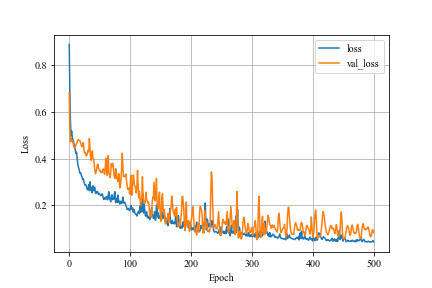

In [388]:
%matplotlib widget
plot_loss(history_time_decay)

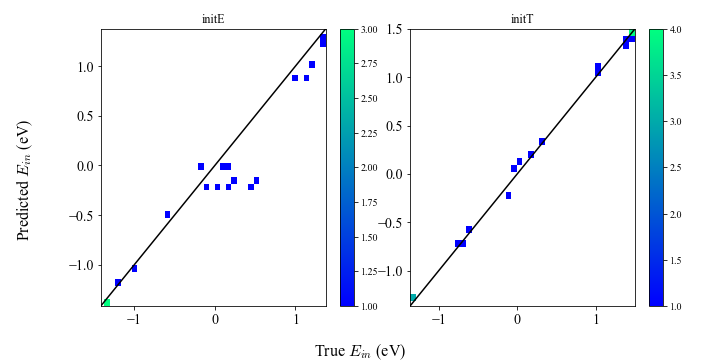

In [393]:
test_predictions = dnn_model.predict(testft)
test_predictions
#scaledpred = test_predictions* train_std['initE'] + train_mean['initE']
#scaledlbl = testlbl* train_std['initE'] + train_mean['initE']
plot_2dhist(test_predictions,testlbl)
#plot_1derror(test_predictions,testlbl)